# Capstone Vinci - Contour detection

# How to ?

1. [Load the clean data](#1-how-to-load-the-clean-data-segments-)
1. [Load and Iterate through the segments](#2-how-to-load-only-segments-form-geojson)
1. [Plot the plan](#3-how-to-plot-the-plan-in-hd-)
1. 🆕 [Use a model](#4-how-to-use-a-model-)
1. 🆕 [Validate the model](#5-how-to-validate-my-model-)
1. 🆕 [Generate the final GeoJson file?](#6-how-to-generate-the-final-geojson-file-)


In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

# own inmports
import utils.parse_geojson as pg
from models.model_CVsegmentation import CVSegmentation
from models.model_polygonise import SegmentBasedClustering
from utils.metrics import average_matched_iou, score_model, test_model_on_sample
from utils.plots import plot_score

# Example of geojson input
file_path = Path("data/geojson/Output5.geojson")

## 1. How to load a GeoJson file ?
[Back to top ↑](#how-to-)

/opt/miniconda3/envs/M2datascience/lib/python3.12/site-packages/shapely/creation.py:460: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, typ, out=out, **kwargs)


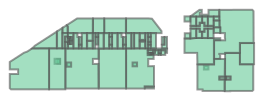

In [3]:
# Without tranformation
gc_raw = pg.load_geometrycollection_from_geojson(file_path)
gc_raw

In [4]:
# With normalization
gc_norm, transform_parameters = pg.load_geojson(file_path)
print(
    f"Saved normalization parameters for inverse transformation : {transform_parameters}"
)
print(f"Loaded {len(gc_norm.geoms)} entities, total {gc_norm.length:.0f}m.")

Saved normalization parameters for inverse transformation : [626.8324607642935, 374.1259288328735, 1]
Loaded 95 entities, total 3594m.


/opt/miniconda3/envs/M2datascience/lib/python3.12/site-packages/shapely/creation.py:460: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, typ, out=out, **kwargs)


## 2. How to load only segments form GeoJson?
[Back to top ↑](#how-to-)

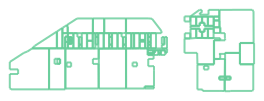

In [5]:
# Get segments in a geometry collection from a raw geojson file

gc_segments = pg.get_segments(file_path)
gc_segments

## 2.bis. How to iterate through the segments?

Segments are into stored into a shapely.GeometryCollection object that is 
iterable through the `gc.geoms` property.
[Back to top ↑](#how-to-)

In [6]:
# use the .geoms property that is iterable
print(type(gc_segments.geoms))

for segment in gc_segments.geoms:
    print(segment)
    # return the coordinates of the two points as ([x1, x2], [y1, y2])
    print(segment.xy)
    break
# >>> <class 'shapely.geometry.base.GeometrySequence'>
# >>> LINESTRING (3.4717383791561587 27.472680807304148, 3.5067598935479767 27.512141737399304)
# >>> (array('d', [3.4717383791561587, 3.5067598935479767]), array('d', [27.472680807304148, 27.512141737399304]))

<class 'shapely.geometry.base.GeometrySequence'>
LINESTRING (743.1393851717198 432.30078552988243, 743.147624456562 447.0702493062334)
(array('d', [743.1393851717198, 743.147624456562]), array('d', [432.30078552988243, 447.0702493062334]))


## 3. How to plot the plan in HD ?
[Back to top ↑](#how-to-)

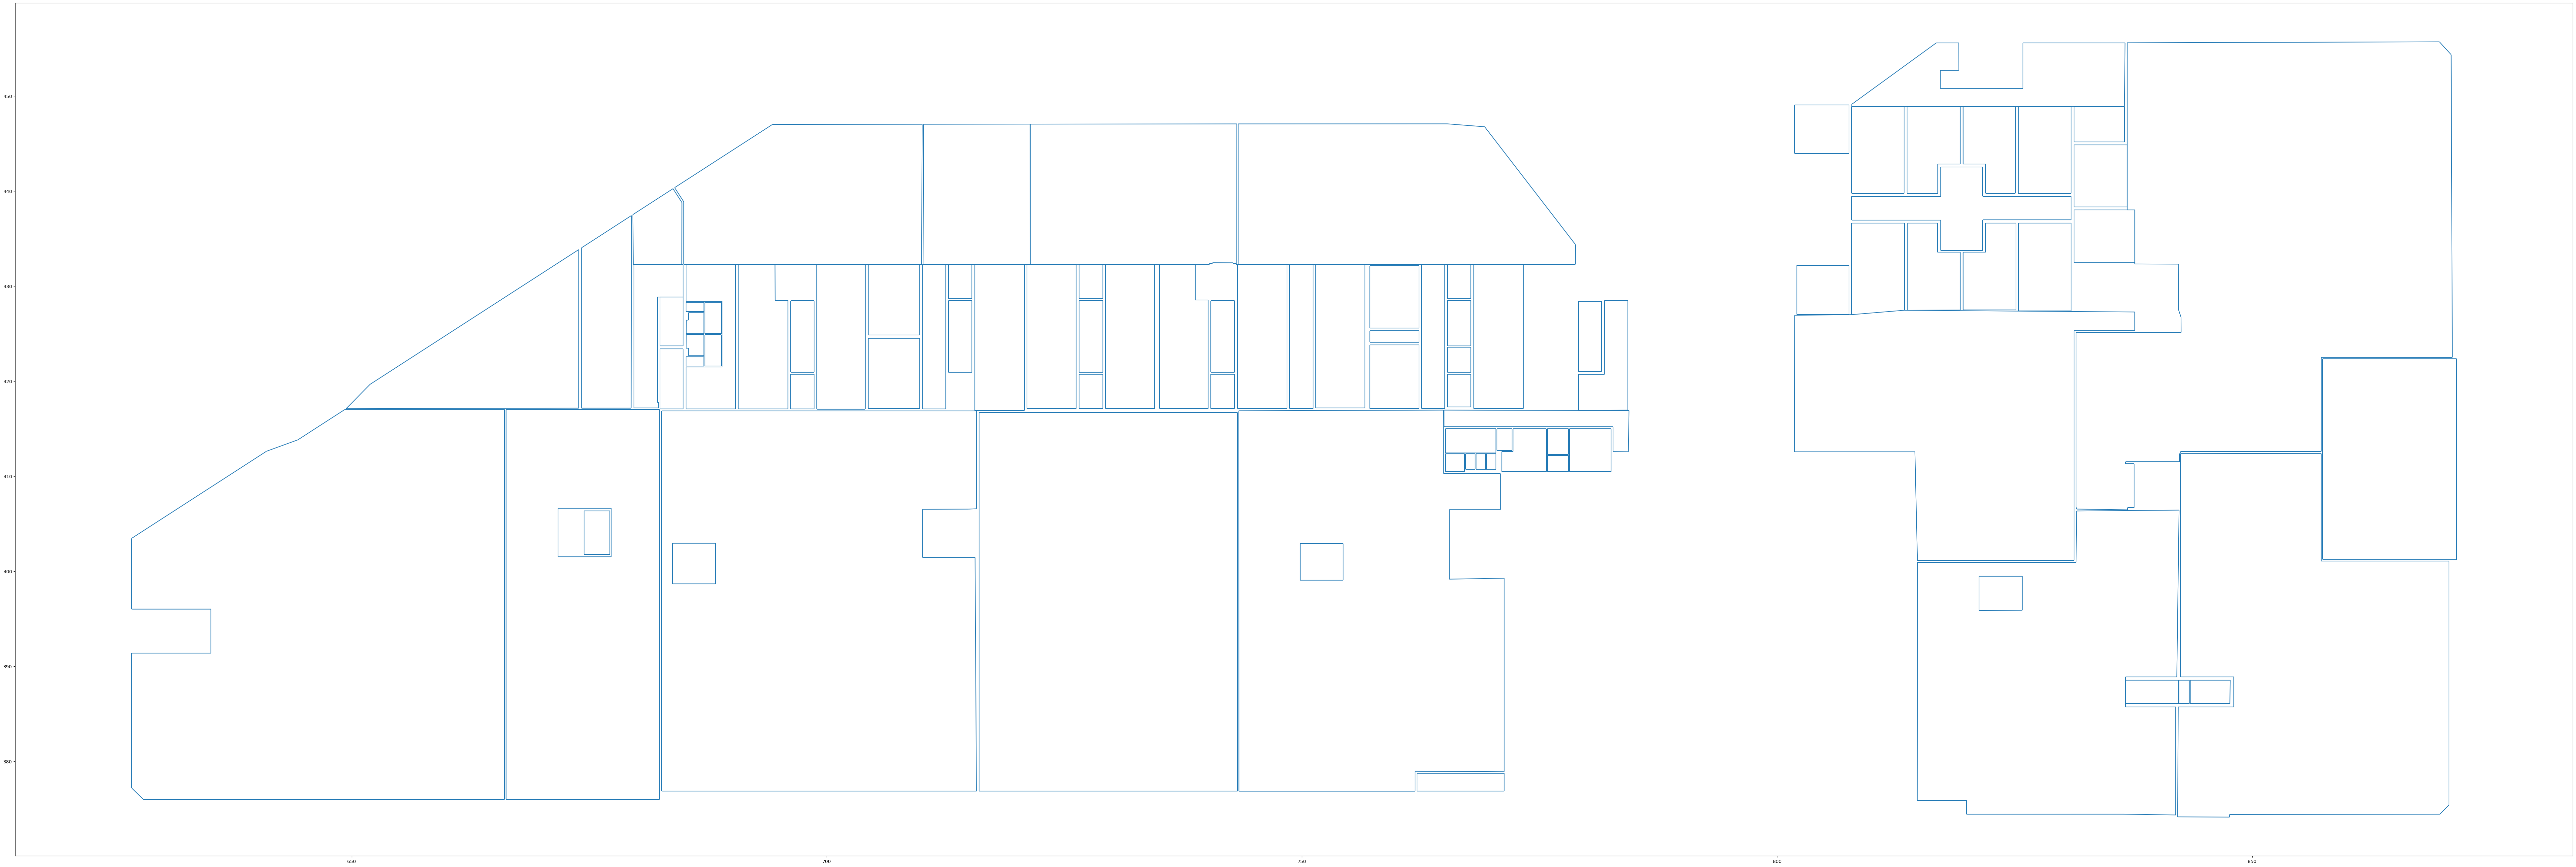

In [7]:
# H1: rise the definition
pg.plot_GeometryCollection(gc_segments, figsize=(100, 100))

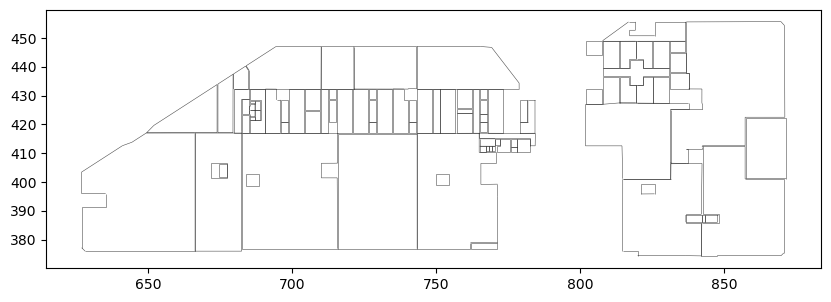

In [8]:
# H2: lower the linewidth. Other pyplot kwargs can be passed to geopandas.GeoSeries.plot
pg.plot_GeometryCollection(
    gc_segments, figsize=(10, 10), color="k", linewidth=0.4, alpha=0.7
)

## 4. How to use a model? 🆕

90 rooms found, displayed as a GeometryCollection:


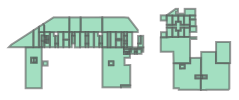

In [9]:
# Instantiate a model from the ./models folder
# Example with polygons
model = SegmentBasedClustering()
# Call predict with the loaded geometry collection
y_pred = model(gc_raw)
print(f"{len(y_pred.geoms)} rooms found, displayed as a GeometryCollection:")
y_pred

Filter: kepp 98/129
98 rooms found, displayed as a GeometryCollection:


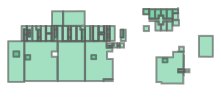

In [10]:
# Example with Computer Vision
model = CVSegmentation()
# Call predict with the loaded geometry collection
y_pred = model(gc_raw)
print(f"{len(y_pred.geoms)} rooms found, displayed as a GeometryCollection:")
y_pred

/opt/miniconda3/envs/M2datascience/lib/python3.12/site-packages/shapely/creation.py:460: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, typ, out=out, **kwargs)


100 rooms found, displayed as a GeometryCollection:


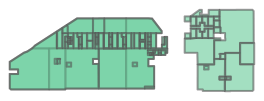

In [11]:
from models.CapstoneVisionSegmentation import CapstoneVisionSegmentation

# Example with CapstoneVisionSegmentation
model = CapstoneVisionSegmentation()
# Call predict with the loaded geometry collection
y_pred = model(gc_raw)
print(f"{len(y_pred.geoms)} rooms found, displayed as a GeometryCollection:")
y_pred

## 5. How to validate my model? 🆕

⚠️ **ONLY on a `spaces-walls` folder !** ⚠️

### 5.1 Display the prediction and score on a sample

#### Vector-based model

Score: 0.800 for SegmentBasedClustering on folder data/spaces-walls/Ecole Centrale Thomas/ARC_BAT_D/Ecole Centrale - Bat D - Plan d'Çtage 00_2nd oeuvre fenetres in with average_matched_iou


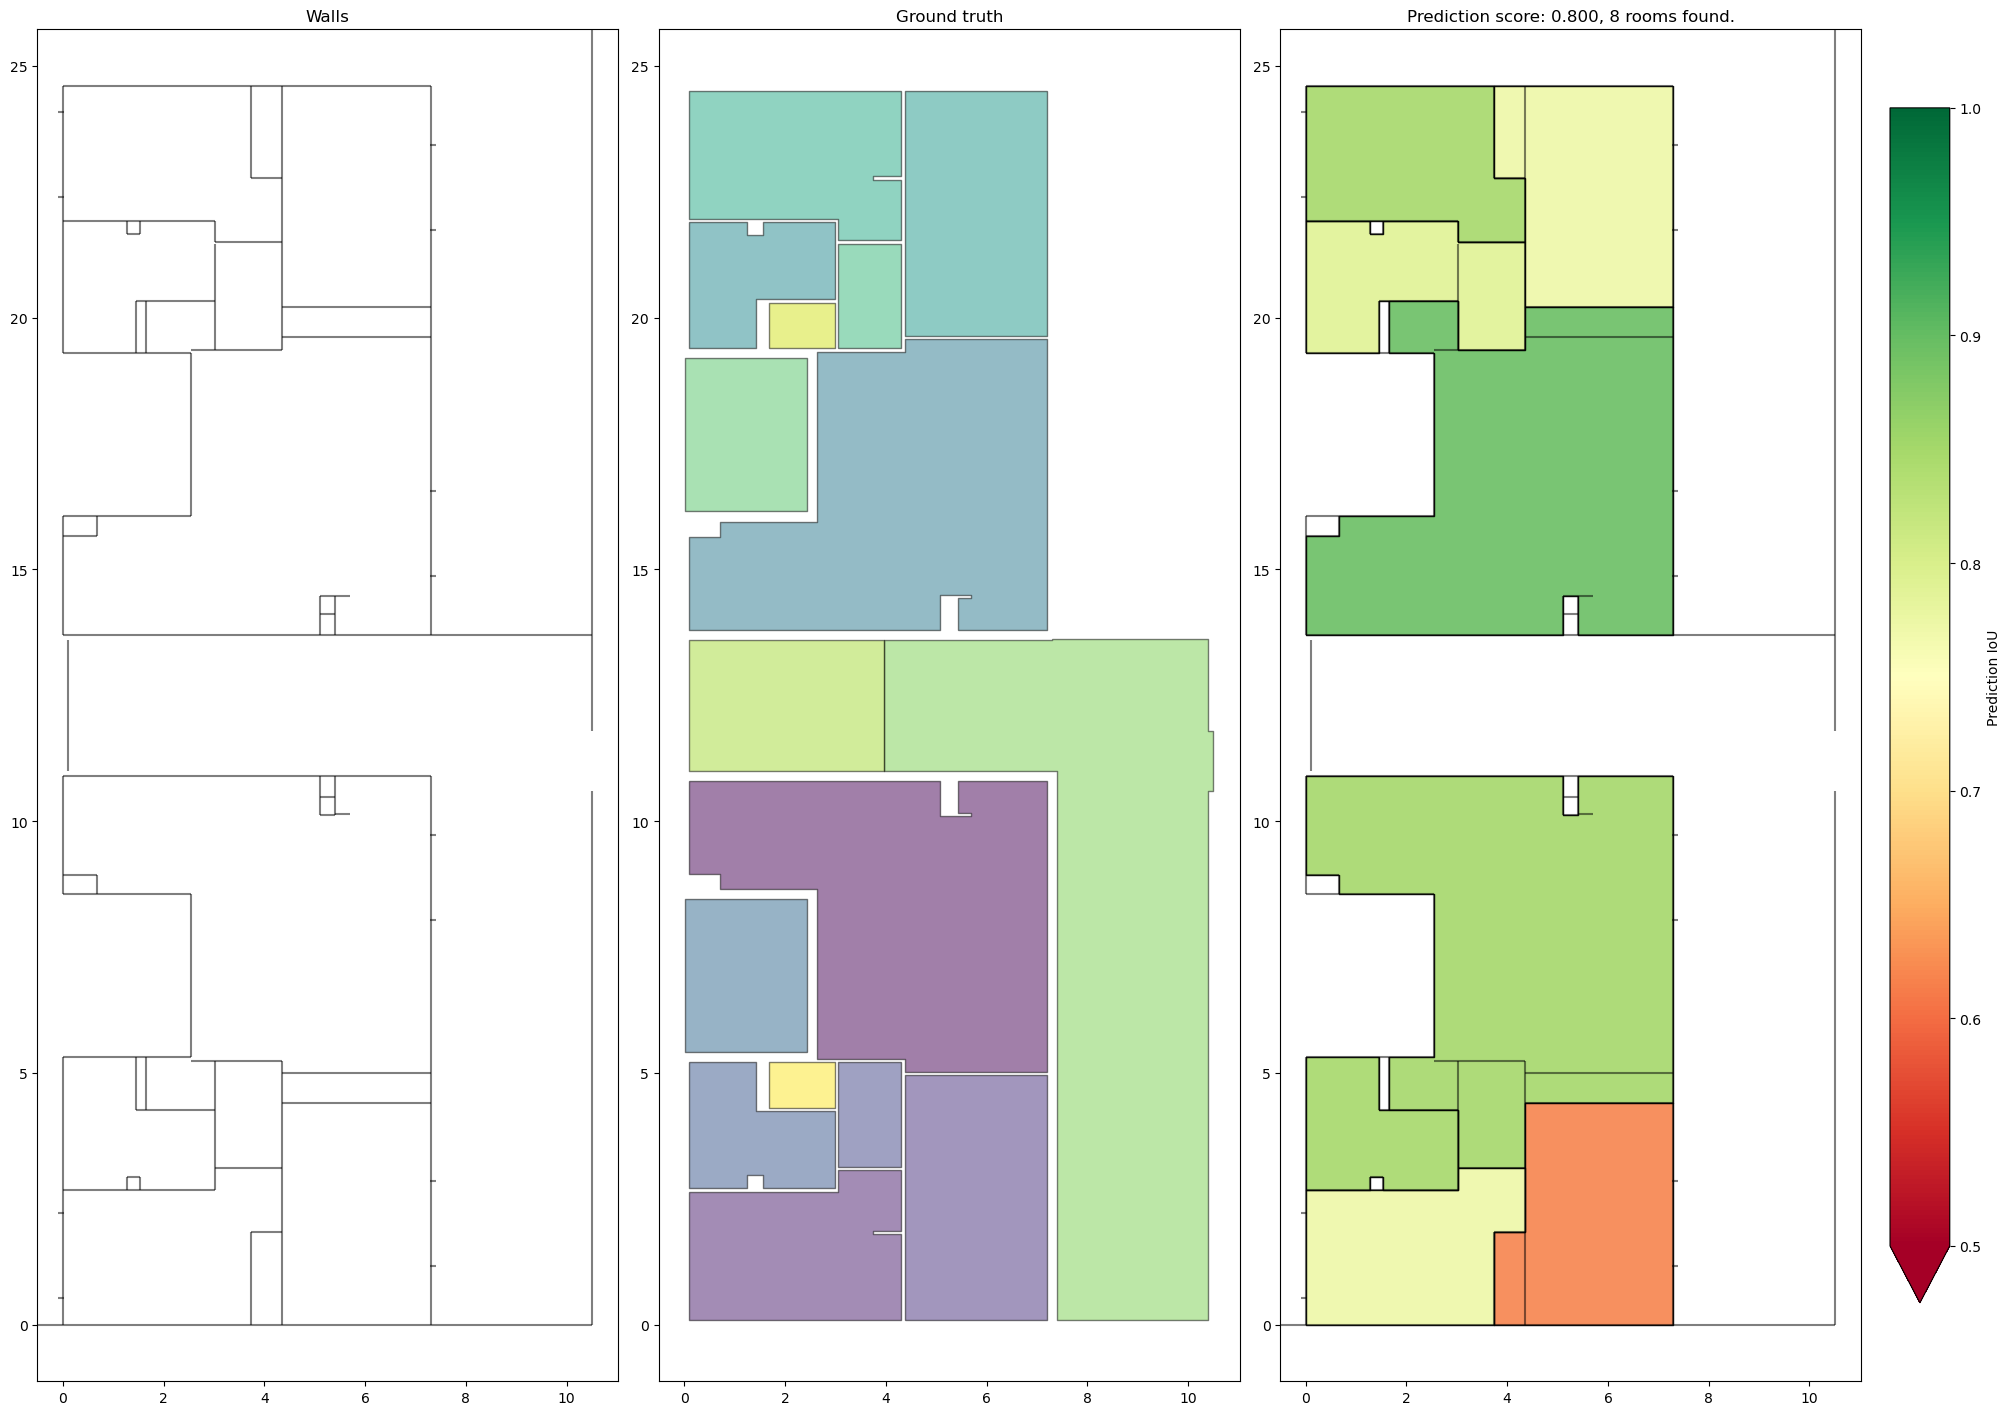

In [12]:
# Chose a Spaces-Walls folder
validate_subfolder = Path(
    # "data/spaces-walls/NHT Tours/plan_etage_T-T3000"
    "data/spaces-walls/Ecole Centrale Thomas/ARC_BAT_D/Ecole Centrale - Bat D - Plan d'Çtage 00_2nd oeuvre fenetres"
    # "data/spaces-walls/CH Lens/CH Lens B1",
)
# Instantiate a model from the ./models folder
# Example with polygons
model = SegmentBasedClustering()
metric = average_matched_iou
# Compute the metric
score = test_model_on_sample(
    model, sample_folder=validate_subfolder, metric=metric
)
print(
    f"Score: {score:.3f} for {model.__name__} on folder "
    f"{validate_subfolder} in with "
    f"{metric.__name__}"
)
# Display the prediction
plot_score(model, validate_subfolder, metric, show_iou=True).show()

#### With segment preprocessing

Score: 0.577 for SegmentBasedClustering on folder data/spaces-walls/Ecole Centrale Thomas/ARC_BAT_D/Ecole Centrale - Bat D - Plan d'Çtage 00_2nd oeuvre fenetres in with average_matched_iou


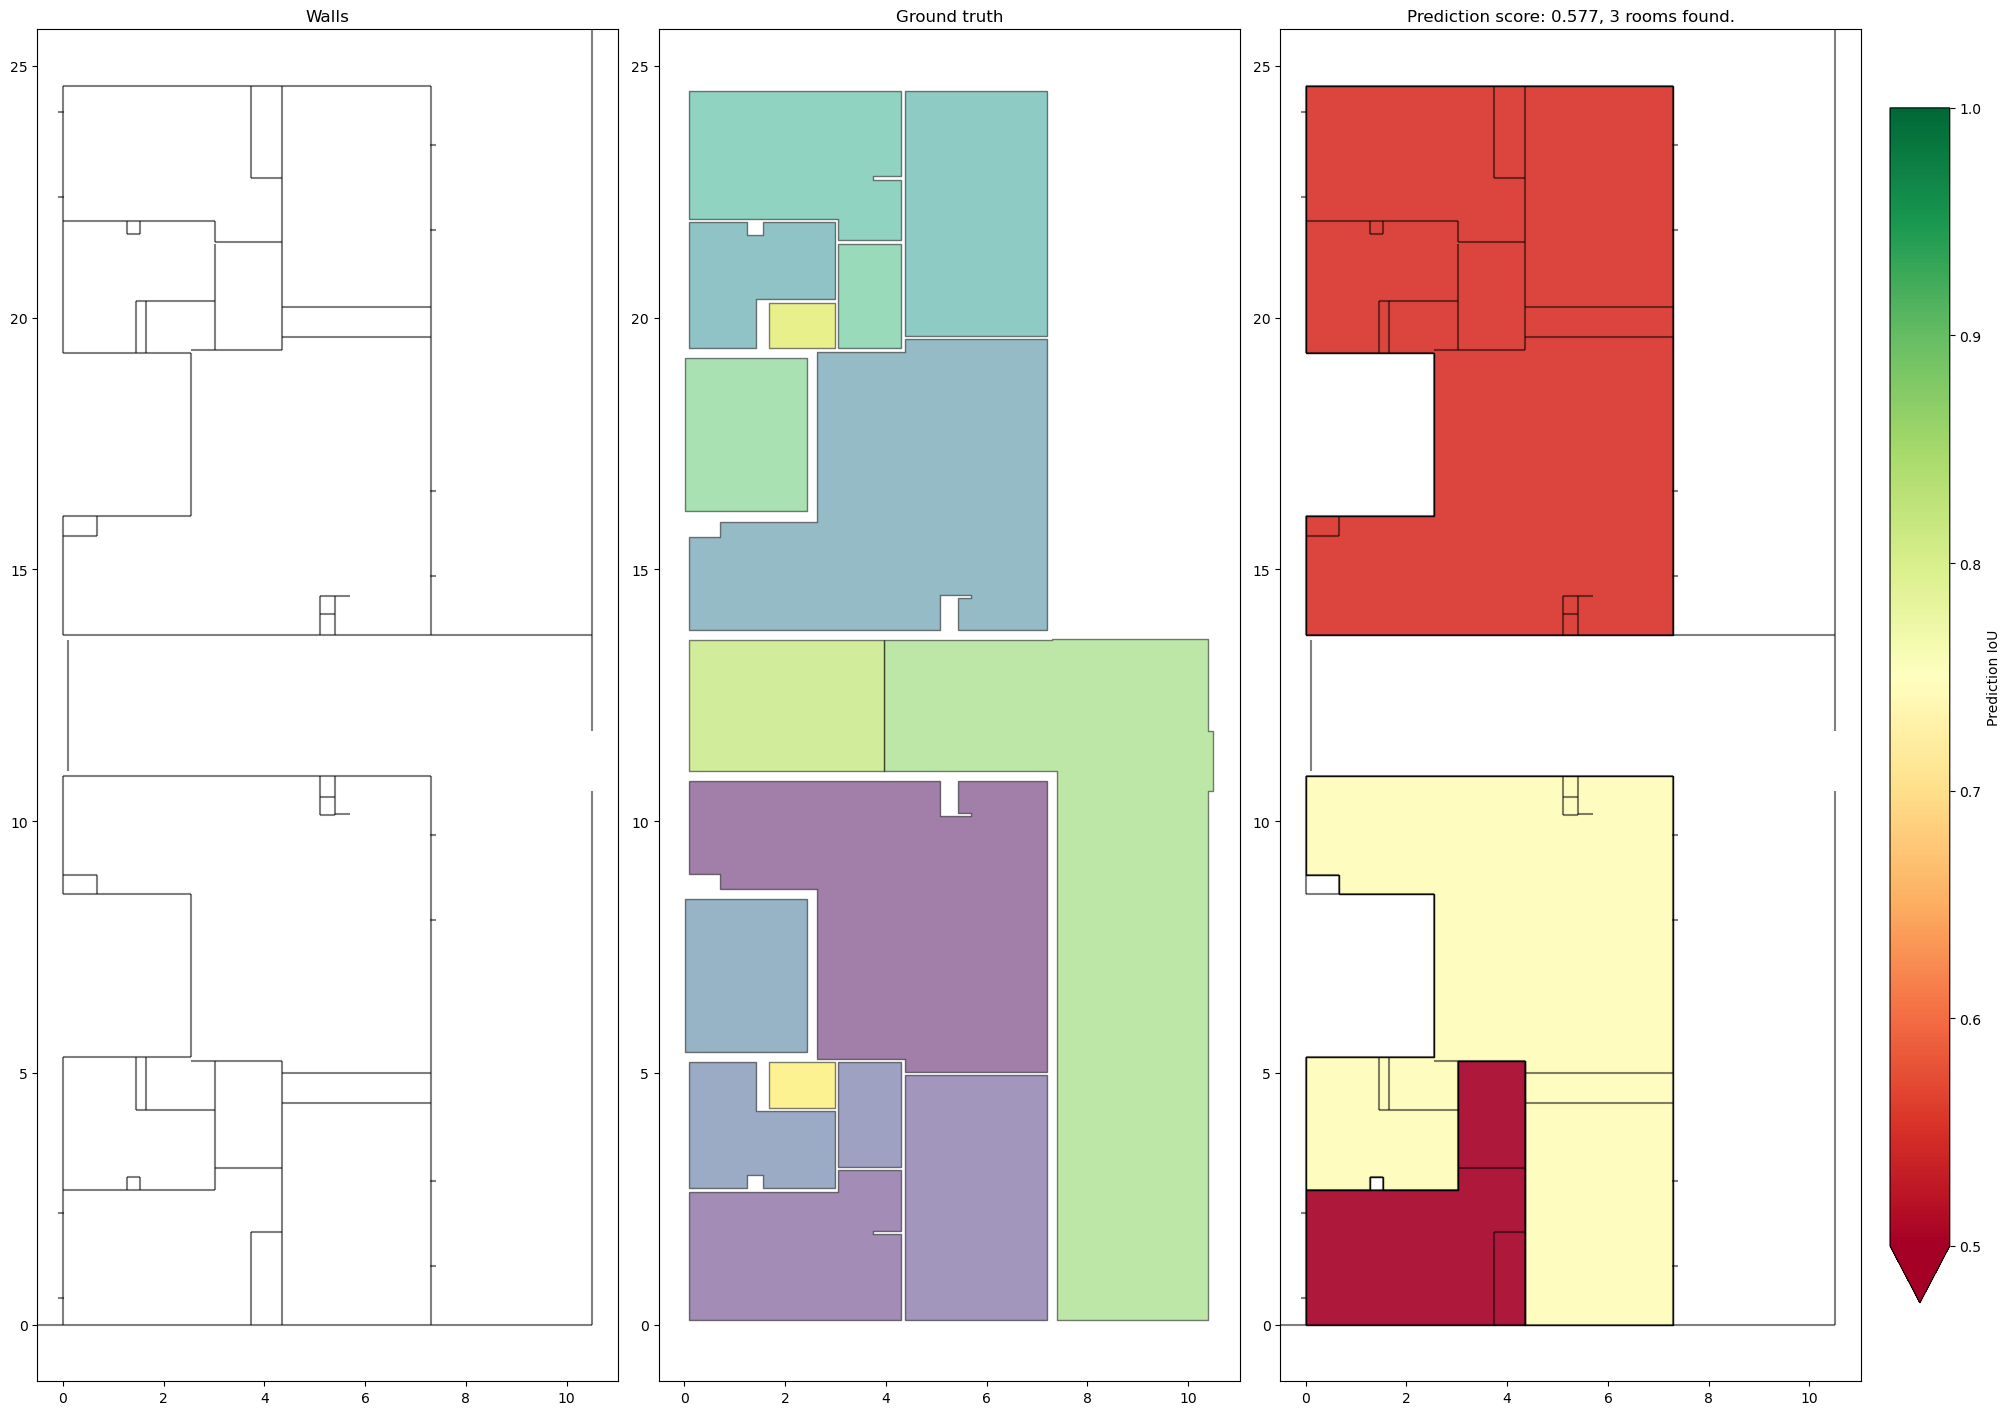

In [13]:
# Same model but with segment preprocessing
model = SegmentBasedClustering(clean_segments=True)
metric = average_matched_iou
# Compute the metric
score = test_model_on_sample(
    model, sample_folder=validate_subfolder, metric=metric
)
print(
    f"Score: {score:.3f} for {model.__name__} on folder "
    f"{validate_subfolder} in with "
    f"{metric.__name__}"
)
# Display the prediction
plot_score(model, validate_subfolder, metric, show_iou=True).show()

#### Vision-based model

Filter: kepp 16/20
Score: 0.603 for CVSegmentation(dpi:50, thickness:11, dilatation:gaussian) on folder data/spaces-walls/Ecole Centrale Thomas/ARC_BAT_D/Ecole Centrale - Bat D - Plan d'Çtage 00_2nd oeuvre fenetres in with average_matched_iou
Filter: kepp 16/20


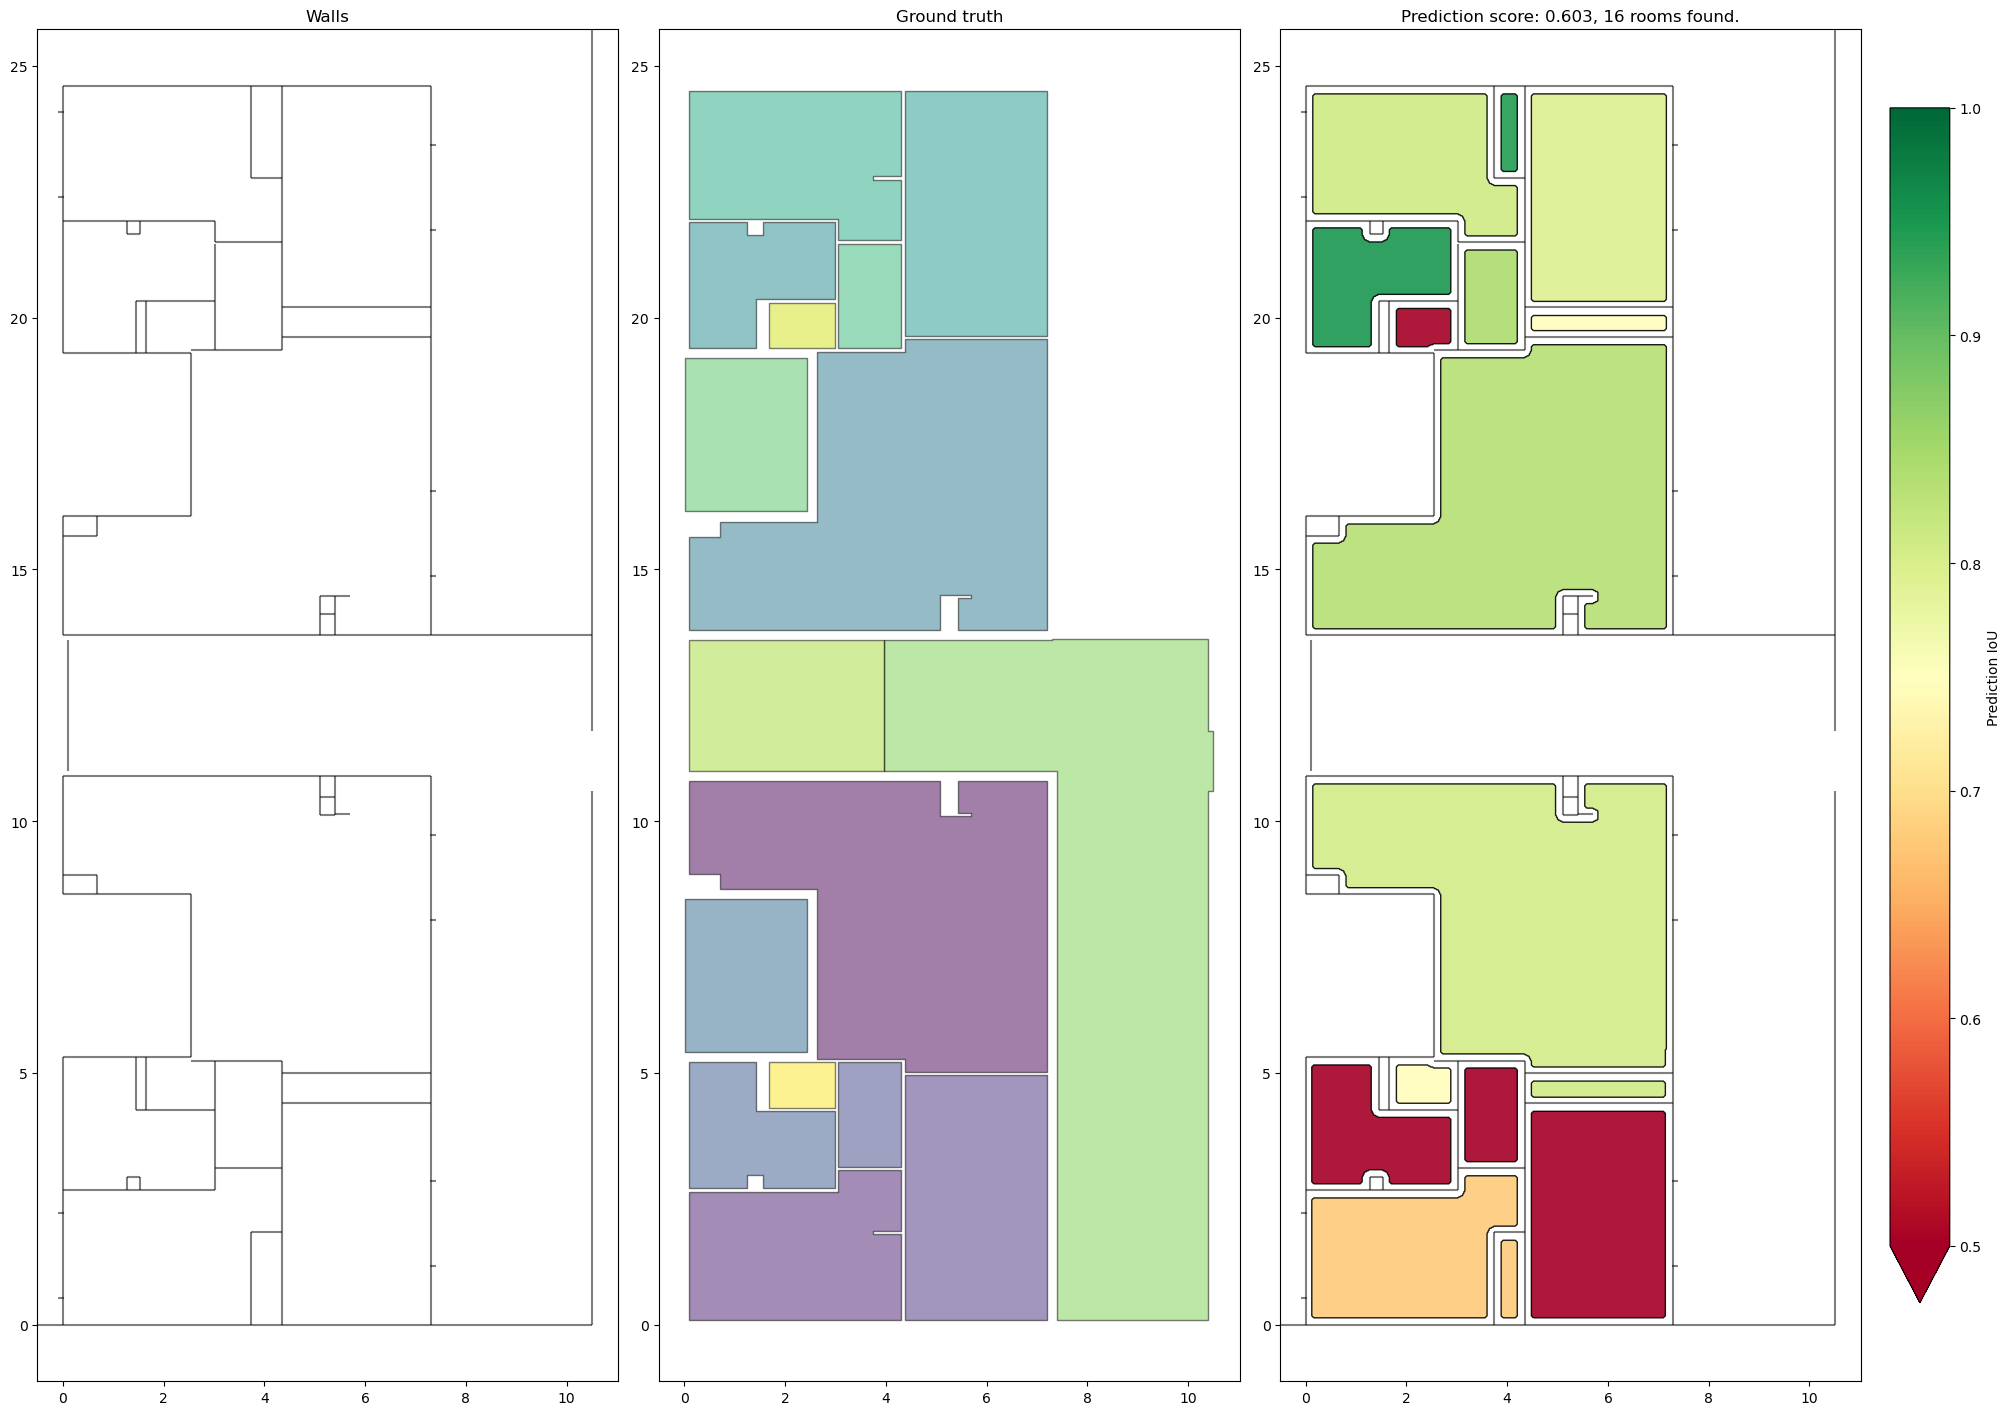

In [14]:
# Example with Computer vision
model = CVSegmentation(thickness=11, surf_min=0.3, surf_max=1_000)
score = test_model_on_sample(
    model,
    sample_folder=validate_subfolder,
    metric=metric,
)
print(
    f"Score: {score:.3f} for {model.__name__} on folder "
    f"{validate_subfolder} in with "
    f"{metric.__name__}"
)
# Display the prediction
plot_score(model, validate_subfolder, metric, show_iou=True).show()

Filter: kepp 16/26
Score: 0.653 for CVSegmentation(dpi:50, thickness:7, dilatation:gaussian) on folder data/spaces-walls/Ecole Centrale Thomas/ARC_BAT_D/Ecole Centrale - Bat D - Plan d'Çtage 00_2nd oeuvre fenetres in with average_matched_iou
Filter: kepp 16/26


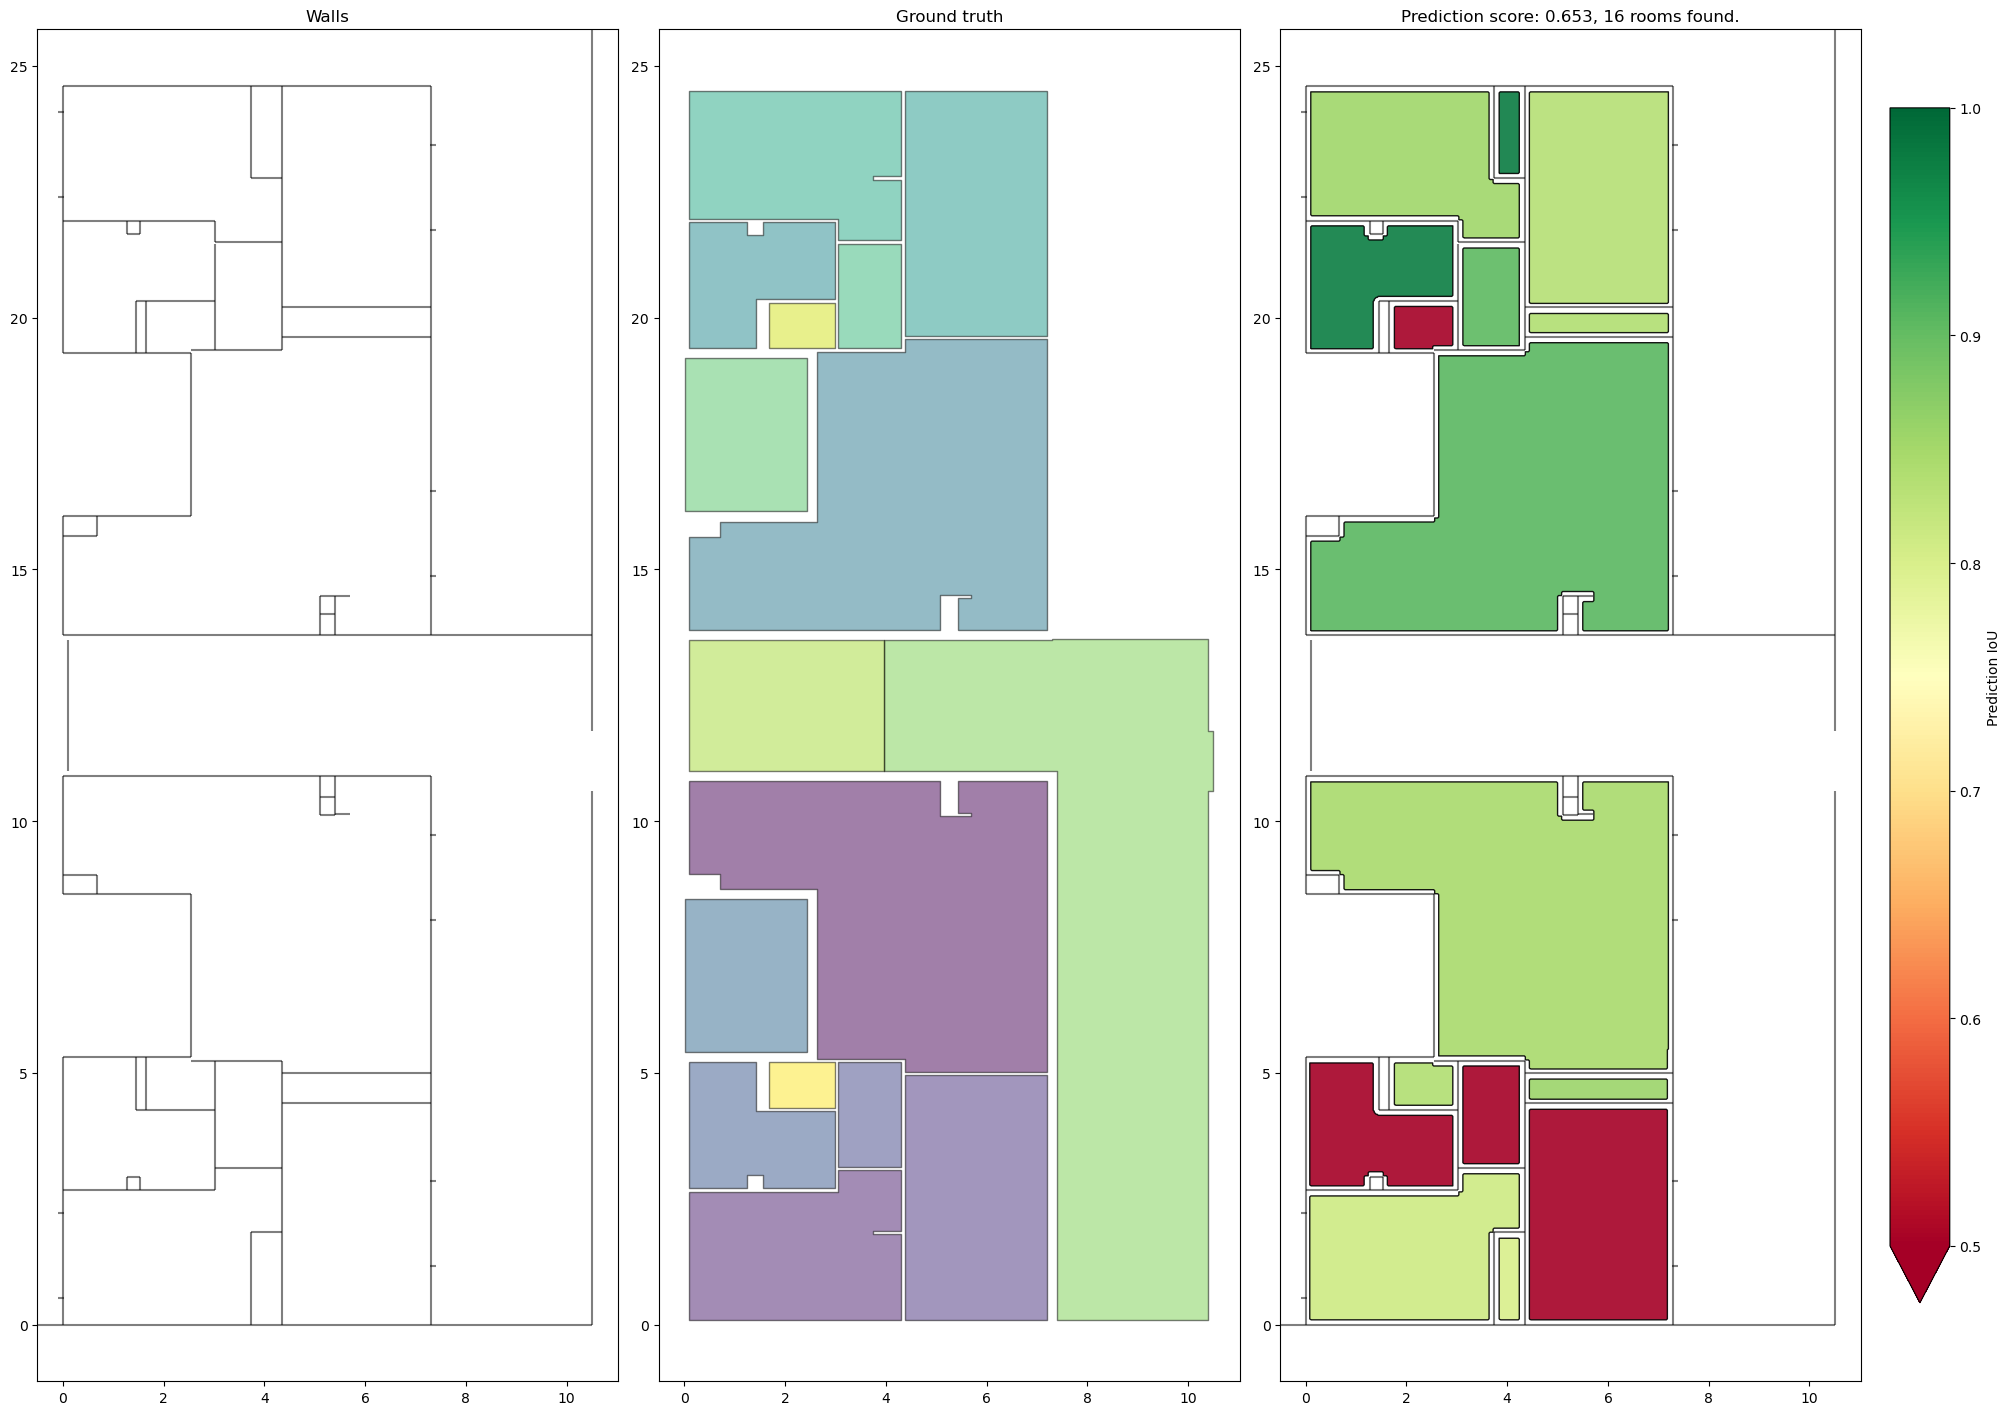

In [15]:
# Example with Computer vision
model = CVSegmentation(thickness=7, surf_min=0.3, surf_max=2_000)
score = test_model_on_sample(
    model,
    sample_folder=validate_subfolder,
    metric=metric,
)
print(
    f"Score: {score:.3f} for {model.__name__} on folder "
    f"{validate_subfolder} in with "
    f"{metric.__name__}"
)
# Display the prediction
plot_score(model, validate_subfolder, metric, show_iou=True).show()

Score: 0.925 for CapstoneSegmentation(dpi:50, thickness:3, method_dilatation:gaussian, surface_min_m2:0.5, surface_min_px:1250.0) on folder data/spaces-walls/Ecole Centrale Thomas/ARC_BAT_D/Ecole Centrale - Bat D - Plan d'Çtage 00_2nd oeuvre fenetres in with average_matched_iou


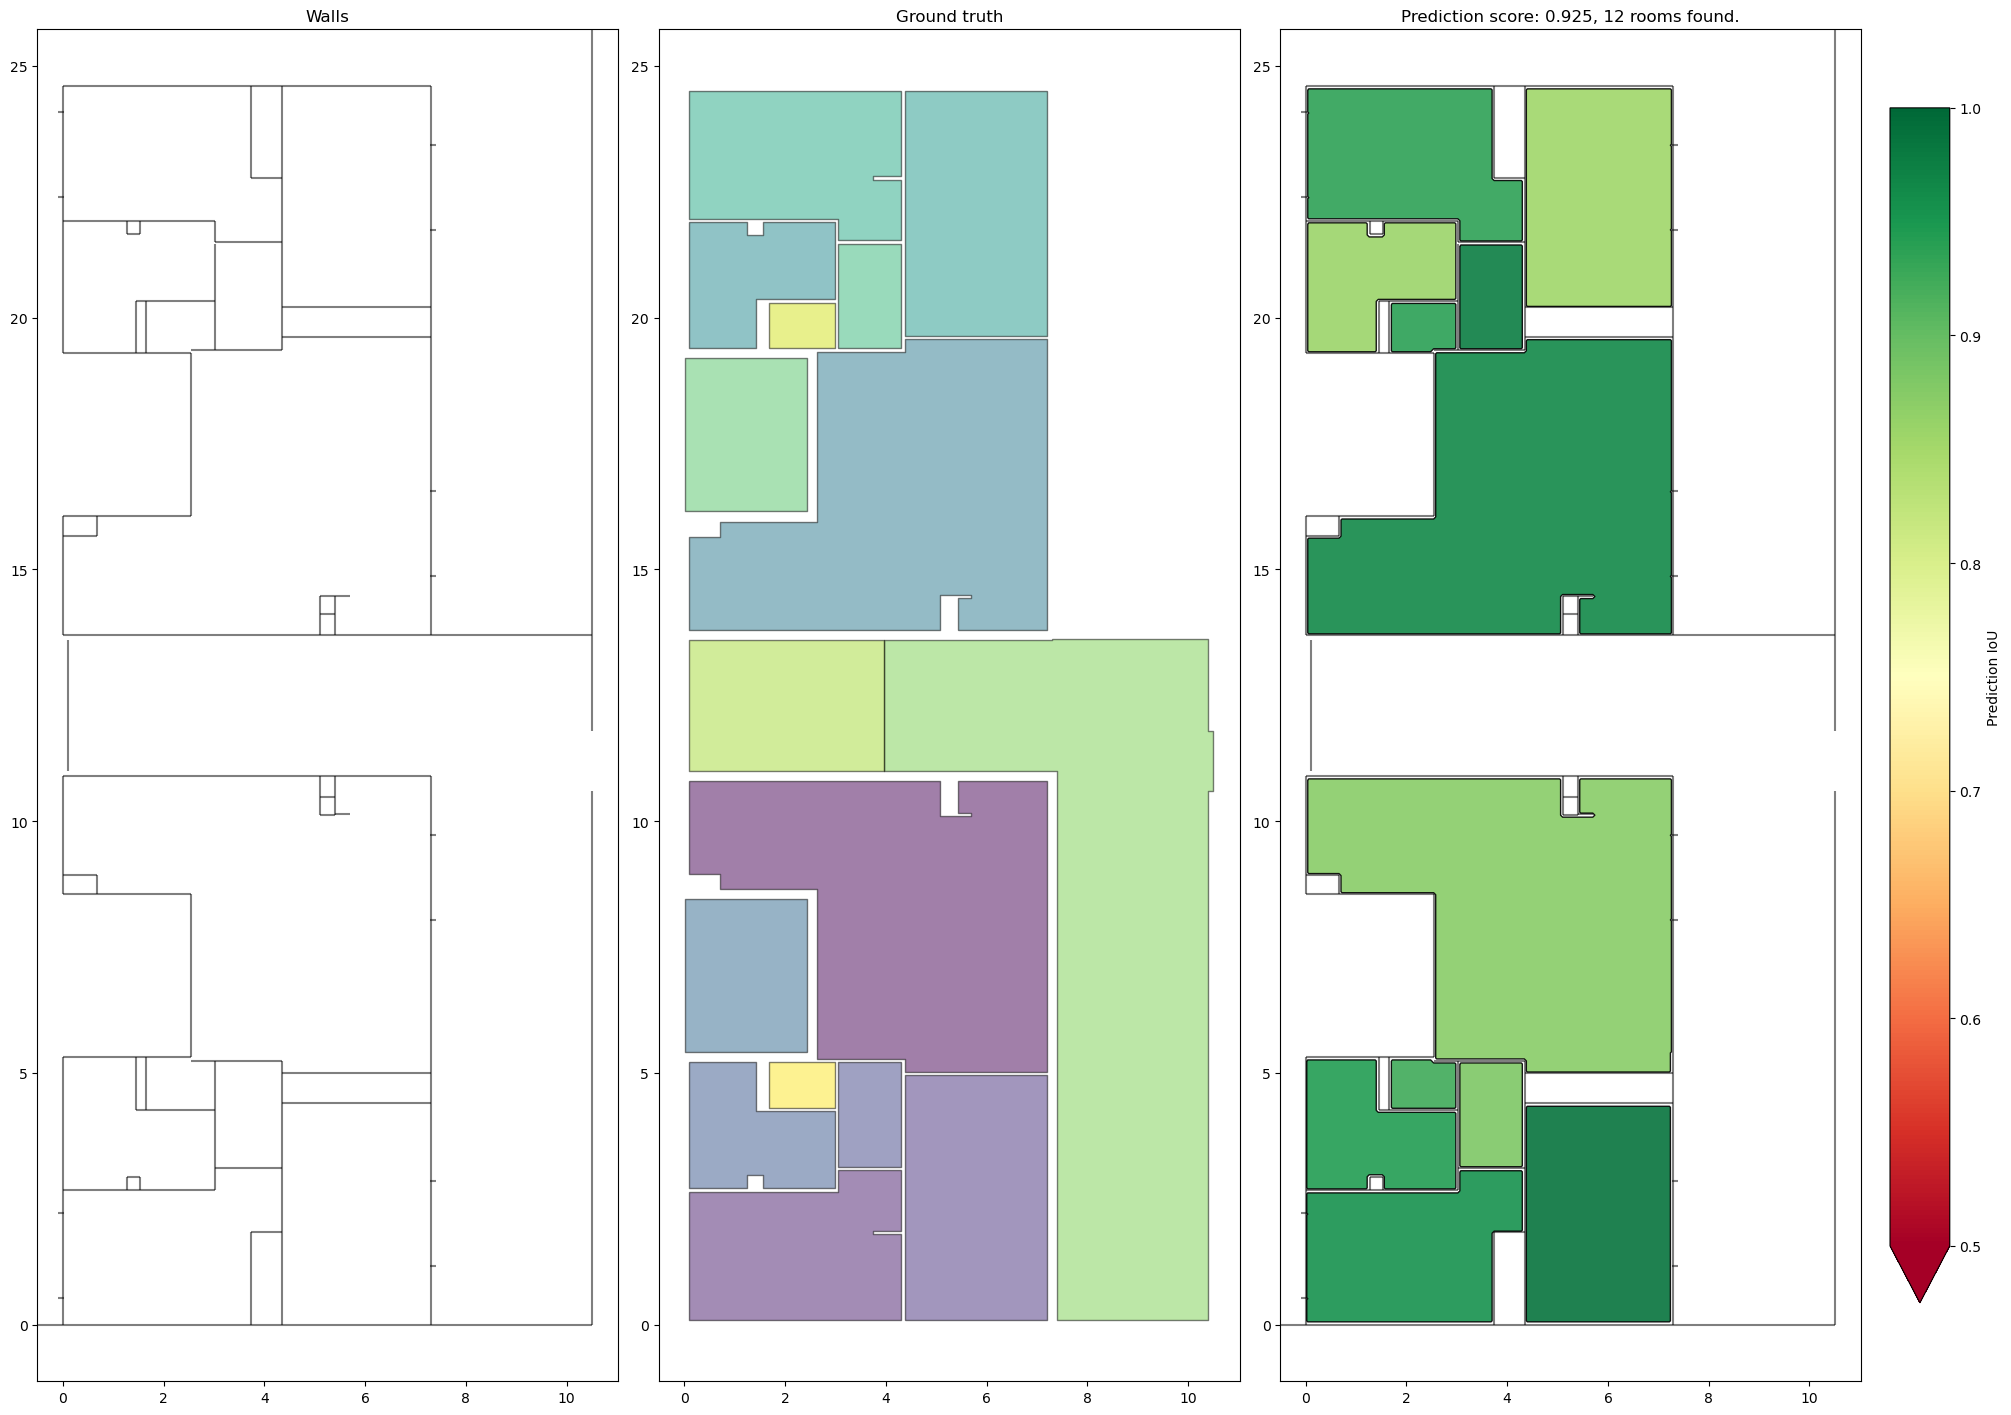

In [16]:
# Example with CapstoneVisionSegmentation

model = CapstoneVisionSegmentation()
score = test_model_on_sample(
    model,
    sample_folder=validate_subfolder,
    metric=metric,
)
print(
    f"Score: {score:.3f} for {model.__name__} on folder "
    f"{validate_subfolder} in with "
    f"{metric.__name__}"
)
# Display the prediction
plot_score(model, validate_subfolder, metric, show_iou=True).show()

#### With segment preprocessing

Filter: kepp 22/48
Score: 0.171 for CVSegmentation(dpi:50, thickness:13, dilatation:gaussian) on folder data/spaces-walls/Ecole Centrale Thomas/ARC_BAT_D/Ecole Centrale - Bat D - Plan d'Çtage 00_2nd oeuvre fenetres in with average_matched_iou
Filter: kepp 22/48


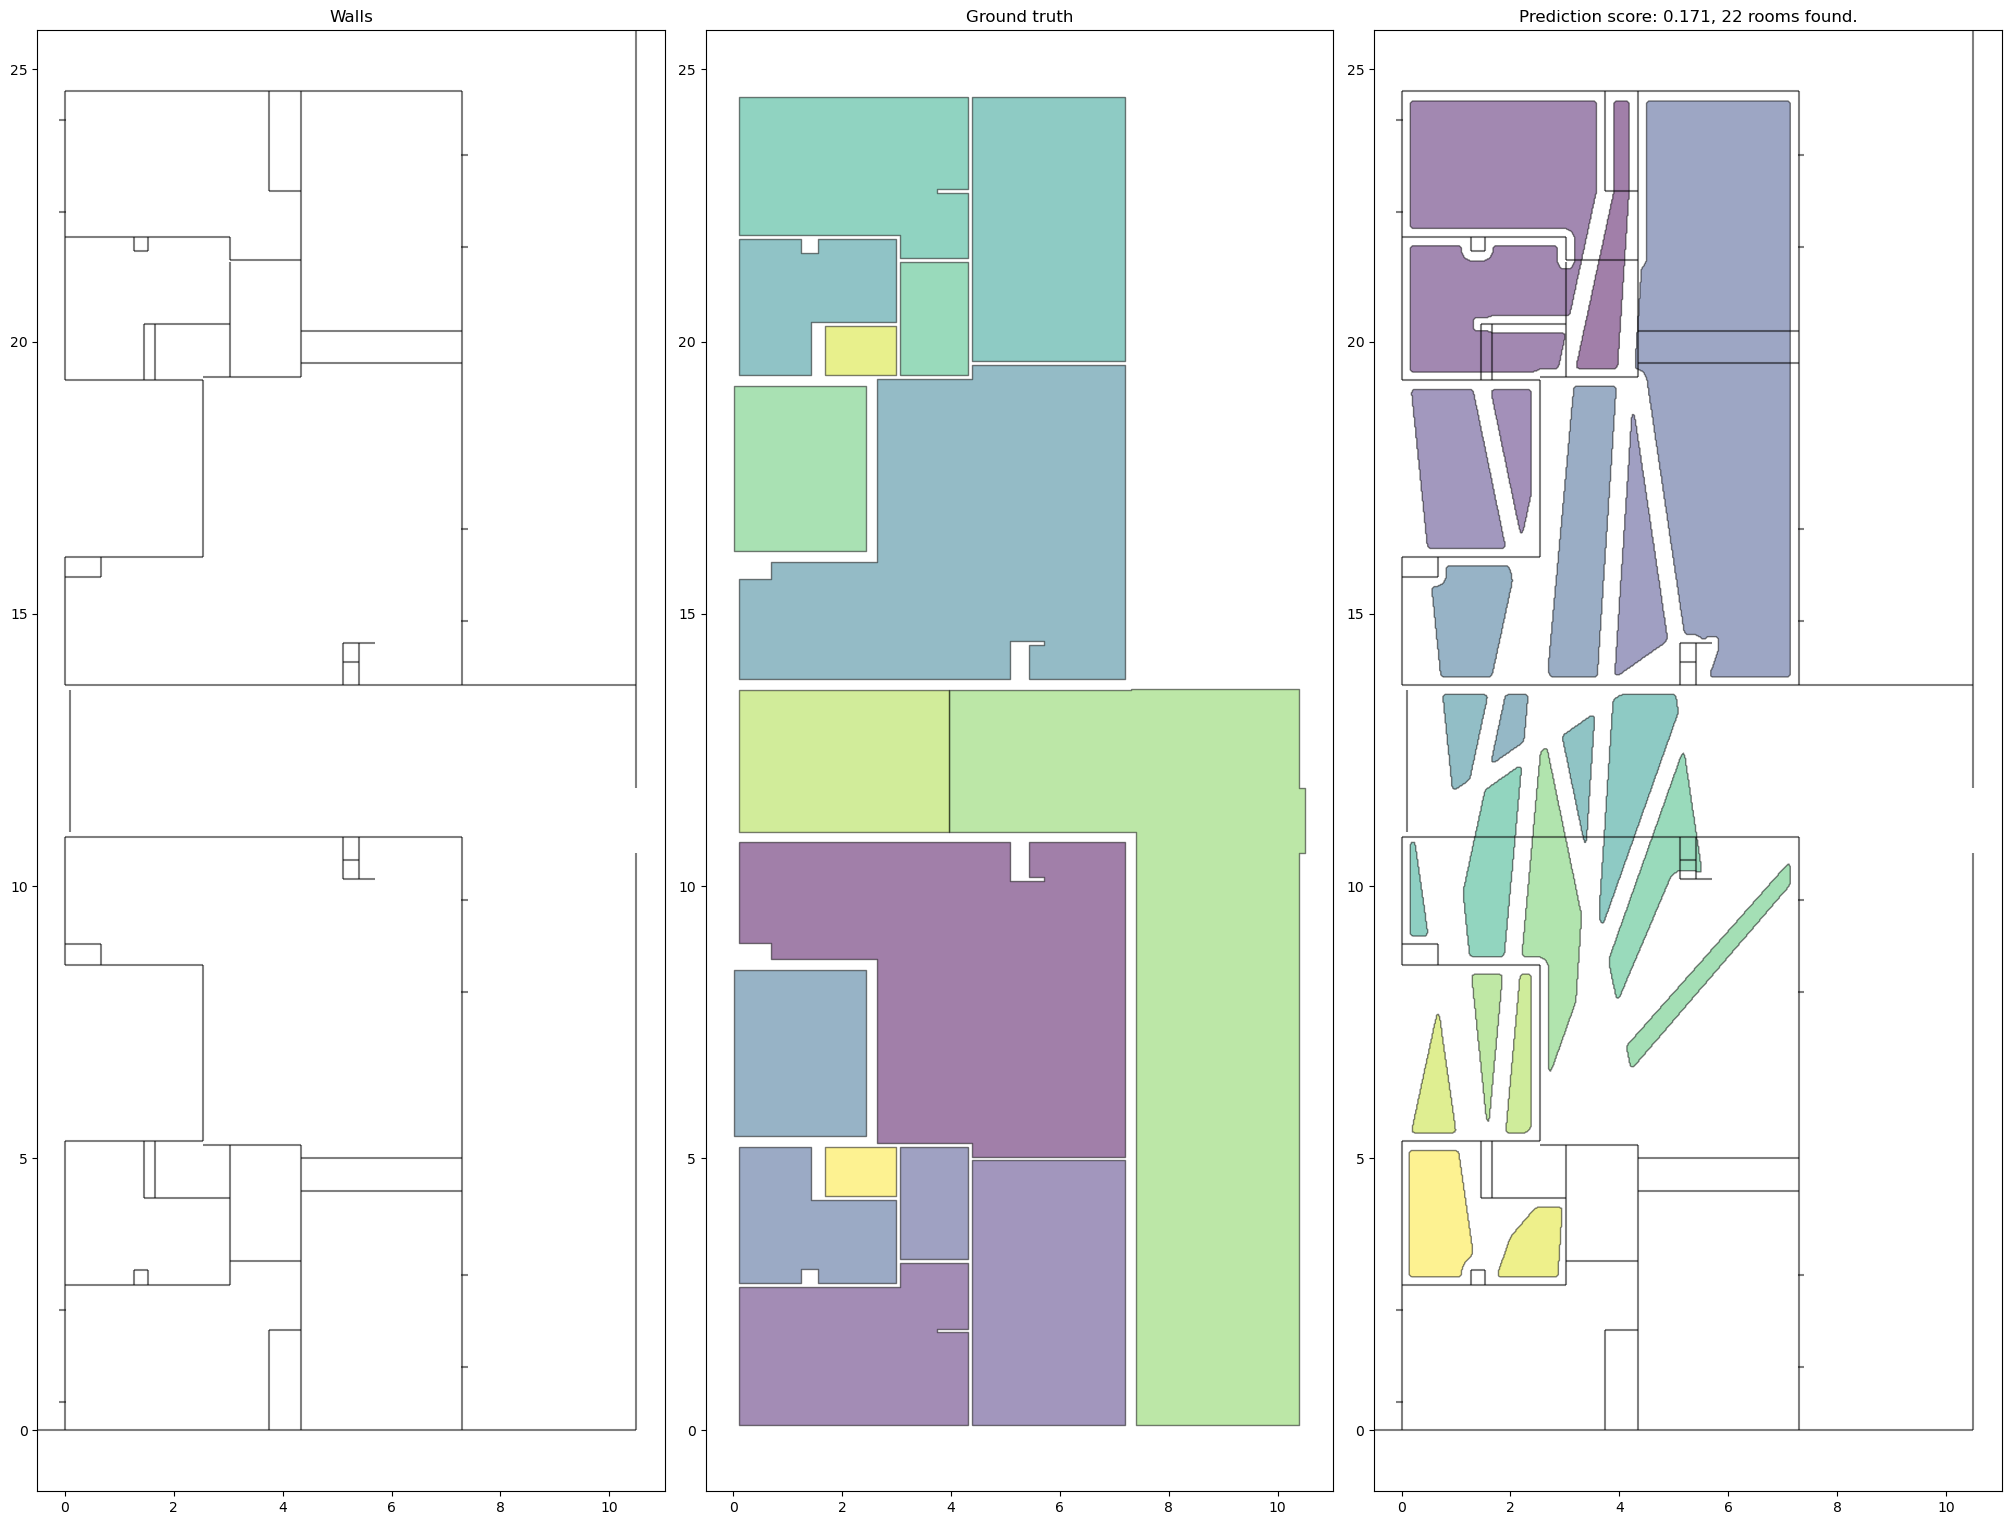

In [17]:
# Example with Computer vision
model = CVSegmentation(
    thickness=13, surf_min=0.3, surf_max=1_000, clean_segements=True
)
score = test_model_on_sample(
    model,
    sample_folder=validate_subfolder,
    metric=metric,
)
print(
    f"Score: {score:.3f} for {model.__name__} on folder "
    f"{validate_subfolder} in with "
    f"{metric.__name__}"
)
# Display the prediction
plot_score(model, validate_subfolder, metric).show()

### 5.2 Score on a whole dataset

In [18]:
# Score on the whole validation set
data_folder = Path("data/spaces-walls/Ecole Centrale Thomas/")
metric = average_matched_iou
model = SegmentBasedClustering()
score_model(model, data_folder, metric=metric)

/opt/miniconda3/envs/M2datascience/lib/python3.12/site-packages/shapely/creation.py:460: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, typ, out=out, **kwargs)
/Users/fabien/Desktop/M2DS_2023-2024/3 - Capstone/2025/CapstoneContour/utils/metrics.py:122: RuntimeWarning: Mean of empty slice
  return np.nanmean(matched_iou(geoms_true, geoms_pred))


SBC: Aucune pièce fermée n'a été trouvée
SBC: Aucune pièce fermée n'a été trouvée
SBC: Aucune pièce fermée n'a été trouvée
SBC: Aucune pièce fermée n'a été trouvée
SBC: Aucune pièce fermée n'a été trouvée
SBC: Aucune pièce ne correspond aux critères de taille
SBC: Aucune pièce ne correspond aux critères de taille
SBC: Aucune pièce ne correspond aux critères de taille
SBC: Aucune pièce ne correspond aux critères de taille
SBC: Aucune pièce ne correspond aux critères de taille
Score: 0.766 for SegmentBasedClustering on folder data/spaces-walls/Ecole Centrale Thomas in 4.51s with average_matched_iou


0.7657037354113367

In [19]:
model = CVSegmentation()
score_model(model, data_folder, metric=metric)

Filter: kepp 108/163
Filter: kepp 105/160
Filter: kepp 22/23
Filter: kepp 106/161
Filter: kepp 3/3
ValueError in folder data/spaces-walls/Ecole Centrale Thomas/ARC_BAT_E/Ecole Centrale - Bat E - plan d'Çtage de faux plafonds 00b_NF: No segments found to generate binary image.
ValueError in folder data/spaces-walls/Ecole Centrale Thomas/ARC_BAT_E/Ecole Centrale - Bat E - Plan d'Çtage 00b_revet: No segments found to generate binary image.
Filter: kepp 3/3
Filter: kepp 3/3
Filter: kepp 13/31
Filter: kepp 13/31
Filter: kepp 12/26
Filter: kepp 13/31
Filter: kepp 12/26
Filter: kepp 12/26
Filter: kepp 12/26
Filter: kepp 13/31
Filter: kepp 12/26
Filter: kepp 13/31
Score: 0.759 for CVSegmentation(dpi:50, thickness:7, dilatation:gaussian) on folder data/spaces-walls/Ecole Centrale Thomas in 0.84s with average_matched_iou


0.7586579350826836

In [20]:
model = CapstoneVisionSegmentation()
score_model(model, data_folder, metric=metric)

ValueError in folder data/spaces-walls/Ecole Centrale Thomas/ARC_BAT_E/Ecole Centrale - Bat E - plan d'Çtage de faux plafonds 00b_NF: Expecting value: line 1 column 53 (char 52)
ValueError in folder data/spaces-walls/Ecole Centrale Thomas/ARC_BAT_E/Ecole Centrale - Bat E - Plan d'Çtage 00b_revet: Expecting value: line 1 column 53 (char 52)
Score: 0.861 for CapstoneSegmentation(dpi:50, thickness:3, method_dilatation:gaussian, surface_min_m2:0.5, surface_min_px:1250.0) on folder data/spaces-walls/Ecole Centrale Thomas in 1.99s with average_matched_iou


0.8605043379455427

## 6. How to generate the final GeoJson file? 🆕

In [21]:
# Instantiate a model from the ./models folder
# Example with polygons
model = SegmentBasedClustering()
# Call predict with the loaded geometry collection
y_pred = model(gc_raw)

pg.export_to_geojson(y_pred, Path("data/prediction") / "predict_5_001.geojson")
print(f"{len(y_pred.geoms)} rooms saved in GeoJson format.")

FileNotFoundError: [Errno 2] No such file or directory: 'data/prediction/predict_5_001.geojson'

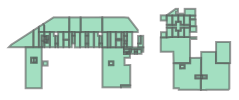

In [ ]:
# Load back to check
pg.load_geometrycollection_from_geojson(
    Path("data/prediction") / "predict_5_001.geojson"
)